<h1>Convex Multi-Task Feature Learning</h1>

<i>Guillaume Richard, Antoine Simoulin</i>

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

data=pd.read_csv('./data/school_results.csv')
X_train = pd.DataFrame(data)
X_train.drop(['grade','tasks'], axis=1, inplace=True)
Y_train = pd.DataFrame(data['grade'])
Tasks = pd.DataFrame(data['tasks'])

In [223]:
import numpy as np
from numpy import linalg as LA

class MLT_Task():
    def __init__(self, X, Y, gamma=1, l_rate=1e-5, n_epoch=15, N = 5, penalization=False):
        self.N = N # dimension representation space
        self.d = X[0].shape[1] # number of features
        self.gamma = gamma # penalization term
        self.l_rate = l_rate # learning rate
        self.n_epoch = n_epoch # number of epochs
        self.X = X # list of matrix of shape (m[i],d)
        self.Y = Y # list of matrix of shape (m[i],1)
        self.T = len(X) # number of tasks
        self.m = [X[i].shape[0] for i in range(len(X))] # number of individuals for each task, list of len(T)
        self.X_conc = np.vstack(X) # aggregated data on all tasks
        self.M = np.vstack(X).shape[0] # total number of individuals
        self.U_0 = np.random.rand(self.d,self.N) # initial representation matrix of shape (d,N)
        self.A_0 = np.random.rand(self.T,self.N) # initial regression matrix of shape (N,T)
        self.penalization = penalization
        
        self.index_task = [0]*(self.T+1)# index of each task in global vector X_low and X_conc
        for t in range(1,self.T):
            self.index_task[t] = self.index_task[t-1] + self.m[t-1]
        self.index_task[self.T] = self.M
        
        self.reverse_index_task = np.zeros(self.M, dtype=int)
        for t in range(self.T):
            self.reverse_index_task[self.index_task[t]:self.index_task[t+1]] = t
        
        print('_'*100)
        print('number of tasks (T) : %i' %self.T)
        print('features space lower dimension (N) : %i' %self.N)
        print('original feature space dimension (d) : %i\n' %self.d)
        
    def Loss_function(self, X, Y, A, U):
        X_low = np.dot(self.X_conc, U) # data in lower dimensional space
        # regression, list of len(T) of matrix of shape (m[i],1)
        Y_hat = [X_low[self.index_task[t]:self.index_task[t+1],:] @ A[t] for t in range(self.T)]
        
        # compute loss
        L = 0
        for t in range(self.T):
            for i in range(self.m[t]):
                L += (Y_hat[t][i]-self.Y[t][i])**2 # average error across tasks
                
        # penalization term
        if self.penalization:
            A2 = LA.norm(A, 2, axis=1)
            A1 = LA.norm(A1, 1)
            pen = self.gamma*A1
            L += pen
        
        return L, Y_hat

    def grad(self, A, U, t, i):
        grad_A_t = -(2*(self.Y[t][i] - self.X[t][i] @ U @ A[t])*(U.T @ self.X[t][i].T))
        grad_U = -(2 * (self.Y[t][i] - self.X[t][i] @ U @ A[t]) * (self.X[t][i].reshape(1, self.d).T @ A[t].reshape(self.N,1).T))
        grads = {"A_t": grad_A_t, "U": grad_U}
        return grads

    # Estimate linear regression coefficients using stochastic gradient descent
    def opt(self):
        r = list(range(self.M))
        A = self.A_0
        U = self.U_0
        for epoch in range(self.n_epoch):
            random.shuffle(r)
            for i in r:
                t =  self.reverse_index_task[i]
                grad = self.grad(A, U, t, i-self.index_task[t])
                # coeff update
                A[t] = A[t] - self.l_rate * grad['A_t']
                U = U - self.l_rate * grad['U']
            self.l_rate = self.l_rate / (1 + epoch)
            loss, pred = self.Loss_function(self.X, self.Y, A, U)
            print('>epoch = %2d, loss = %3.2f' % (epoch, np.sqrt(loss/self.M)))
        print('_'*100)
        return A, U, pred

____________________________________________________________________________________________________
number of tasks (T) : 139
features space lower dimension (N) : 5
original feature space dimension (d) : 28

>epoch =  0, loss = 12.36
>epoch =  1, loss = 11.79
>epoch =  2, loss = 11.47
>epoch =  3, loss = 11.44
>epoch =  4, loss = 11.39
>epoch =  5, loss = 11.39
>epoch =  6, loss = 11.39
>epoch =  7, loss = 11.39
>epoch =  8, loss = 11.39
>epoch =  9, loss = 11.39
____________________________________________________________________________________________________


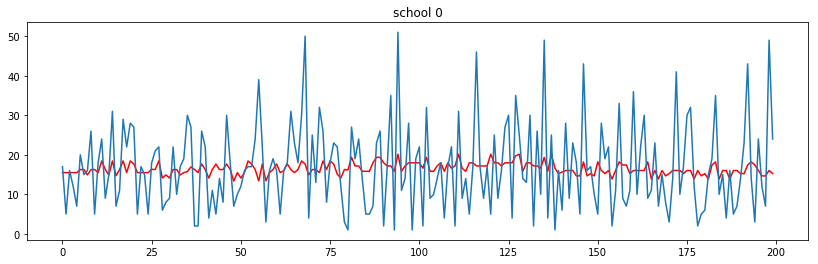

In [224]:
# test parameters
X_train_list = [X_train[Tasks.tasks == t].values for t in Tasks.tasks.unique()]
Y_train_list = [Y_train[Tasks.tasks == t].values[:,0] for t in Tasks.tasks.unique()]

MLT_Task_test = MLT_Task(X_train_list, Y_train_list, N=5, n_epoch=10, l_rate=1e-5)
_, _, pred = MLT_Task_test.opt()

fig, _ = plt.subplots(figsize=[14,4])
plt.plot(pred[0],'r')
plt.plot(Y_train_list[0])
plt.title('school 0')
plt.show()